In [ ]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from tqdm import tqdm
import multiprocessing as mp
import re
import pickle
from itertools import product

In [ ]:
# Format plots
sns.set(style="white",
        font_scale=1.5,
        rc={'figure.figsize':(12,6)})

# Make directory for figures
if not os.path.isdir("./figures/"):
    os.mkdir("./figures/")

In [ ]:
# Define the parameters for simulation
paramDic = {"rS":.027, "rR":.027, "cRS":1., "cSR":1.,"dD":1.0, 
            "k":1., "D":0, "theta":1, 'DMax':1.2}
paramDic['dR'] = 0.2*paramDic['rR']
paramDic['dS'] = 0.2*paramDic['rS']
nTimePts = 100
dt = 1.
intervalLength = 1

def GenerateParameterDic(initialSize,rFrac,cost,turnover,paramDic):
    """
    Generate parameter dictionary for given initial conditions, coef_effect and turnover values.
    :param coef_effect:
    :param turnover:
    :param paramDic:
    :return:
    """
    # Generate ICS
    initialStateVec = [initialSize * (1 - rFrac), initialSize * rFrac, 0, paramDic['DMax']]
    initialStateVec[2] = paramDic['theta'] * (initialStateVec[0] + initialStateVec[1])

    # Generate params   addapted for increasing competition coefficient
    paramDic = paramDic.copy()
    paramDic['cSR'] = (1+cost)*paramDic['cSR']
    paramDic['dR'] = turnover*paramDic['rR']
    paramDic['dS'] = turnover*paramDic['rS']
    return initialStateVec,paramDic




In [ ]:
# --------------------------- Model -----------------------------------------------------

def lotka_volterra(t, uVec, paramDic):
    s, r, v, c = uVec
    dudtVec = np.zeros_like(uVec) 
    dudtVec[0] = paramDic['rS']*(1-paramDic['dD']*c)*(1 - (s + paramDic['cRS'] * r)/paramDic['k']) * s - paramDic['dS']*s
    dudtVec[1] = paramDic['rR']*(1 - (r + paramDic['cSR'] * s)/paramDic['k'])*r - paramDic['dR']*r
    dudtVec[2] = paramDic['theta']*(dudtVec[0] + dudtVec[1])
    dudtVec[3] = 0
    return (dudtVec)


In [ ]:
# --------------------------- Simulation -----------------------------------------------------
def Simulate_pestice_max(initialStateVec,paramDic,modelFun,t_end=None,t_span=None,t_eval=None,nTimePts=100,**kwargs):
    t_span = t_span if t_span is not None else (0, t_end)
    t_eval = t_eval if t_eval is not None else np.linspace(t_span[0],t_span[1],nTimePts)
    solObj = scipy.integrate.solve_ivp(lambda t, uVec: modelFun(t,uVec,paramDic), y0=initialStateVec,
                                       t_span=t_span,t_eval=t_eval,**kwargs)
    return pd.DataFrame({"Time": solObj.t, "S": solObj.y[0, :], "R": solObj.y[1, :],
                              "V":solObj.y[2,:], "D": solObj.y[3, :]})

def Simulate_non_int_fixed_target(initialStateVec,paramDic,modelFun,
                               atThreshold=0.5,intervalLength=3,refSize=None,t_end=None,t_span=None,t_eval=None,nTimePts=100,**kwargs):
    t_span = t_span if t_span is not None else (0, t_end)
    t_eval = t_eval if t_eval is not None else np.linspace(0,t_end,nTimePts)
    resultsDFList = []
    currInterval = [t_span[0],t_span[0]+intervalLength]
    refSize = initialStateVec[2] if refSize is None else refSize
    dose = initialStateVec[-1]
    currCycleId = 0
    while currInterval[1] <= t_end: 
        # Simulate
        resultsDf = Simulate_pestice_max(initialStateVec,modelFun=modelFun,
                                         paramDic=paramDic,
                                         t_span=(currInterval[0], currInterval[1]),
                                         t_eval=np.linspace(currInterval[0], currInterval[1],1000))
        resultsDf['CycleId'] = currCycleId
        resultsDFList.append(resultsDf)

        # Update dose
        if resultsDf.V.iat[-1] > refSize:
            currCycleId += (dose==0)
            dose = paramDic['DMax']
        elif resultsDf.V.iat[-1] < (1-atThreshold)*refSize:
            dose = 0
        else:
            dose = (dose > 0)*paramDic['DMax']
        initialStateVec = [resultsDf.S.iat[-1], resultsDf.R.iat[-1], resultsDf.V.iat[-1], dose]

        # Update interval
        currInterval = [x+intervalLength for x in currInterval]
    resultsDf = pd.concat(resultsDFList)
    # Interpolate to the desired time grid
    trimmedResultsDic = {'Time':t_eval}
    for variable in ['S','R','V','D','CycleId']:
        f =  scipy.interpolate.interp1d(resultsDf.Time,resultsDf[variable],fill_value="extrapolate")
        trimmedResultsDic = {**trimmedResultsDic,variable:f(t_eval)}
    return pd.DataFrame(data=trimmedResultsDic)

In [ ]:
def ProfileTreatmentStrategies(modelFun,paramDic,atThresholdList=[0.3, 0.5],intervalLength=0.3,dt=1.,
                               initialSizeList=np.linspace(0.25,0.75,5),
                               rFracList=[0.1,0.01,0.001],
                               tumourSizeWhenProgressed=1.2,cureThreshold=0.1,enableProgressBar=True):
    tmpDicList = []
    for initialTumourSize,rFrac in tqdm([(x,y) for x in initialSizeList for y in rFracList],disable=enableProgressBar==False):
        initialStateVec,_ = GenerateParameterDic(initialSize=initialTumourSize,rFrac=rFrac,cost=0,turnover=0,paramDic=paramDic)
        maxTolerableBurden = initialTumourSize*tumourSizeWhenProgressed
        tumourBurdenWhenCured = cureThreshold*initialTumourSize

        # 0. Check that tumour can progress
        rMax = np.inf
        if modelFun.__name__=='lotka_volterra':
            rMax = (1-paramDic['dR']/paramDic['rR'])*paramDic['k']
        if rMax < maxTolerableBurden:
            for strategy in ["MTD"]+[str(thresh) for thresh in atThresholdList]:
                tmpDicList.append({"TreatmentBranch": strategy,
                                   "RFrac": rFrac, "InitialTumourSize": initialTumourSize,
                                   "Cured": False, "IndefiniteControl":True, "TimeToFailure": np.nan, "RelTimeGained": np.nan,
                                   "NCycles": np.nan})
            continue

        # 1. Simulate MTD until cure or failure
        r0 = max(initialStateVec[1],0.001) # Make sure I assume at least some r0 for this calculation, otherwise it blows up
        rR = paramDic.get('rR',paramDic.get('p',0.03))
        t_end = np.log((1-r0)/(r0*(1/maxTolerableBurden-1)))/rR
        finalTumourBurden = 0
        cured = False
        currStateVec = initialStateVec
        currTime = 0
        # a) Figure out how long to simulate for. If MTD cures the tumour we skip this
        # scenario. If it doesn't, then we will simulate until 2x TTP of MTD. To do so,
        # we here have to determine TTP.
        while finalTumourBurden<maxTolerableBurden-1e-6 and not cured: # 1e-6 to deal with cases when the maxBurden is so close to KEff that the ODE solver's numerical error becomes a problem.
            resultsDf = Simulate_pestice_max(initialStateVec=currStateVec,
                                             modelFun=modelFun,paramDic=paramDic,
                                             t_span=(currTime,t_end))
            finalTumourBurden = resultsDf.V.iloc[-1]
            cured = np.any(resultsDf.V<tumourBurdenWhenCured)
            currStateVec = [resultsDf.S.iloc[-1], resultsDf.R.iloc[-1], resultsDf.V.iloc[-1], 1]
            currTime = t_end
            t_end *= 1.1

        # Don't simulate if MTD cures the tumour
        if cured:
            tmpDicList.append({"TreatmentBranch":"MTD",
                               "RFrac": rFrac, "InitialTumourSize":initialTumourSize,
                               "Cured":True, "IndefiniteControl":False, "TimeToFailure":np.nan,"RelTimeGained":np.nan,
                               "NCycles":np.nan})
            continue

        # b) Get the estimate for TTP using the same function and time grid that I will be using for the AT.
        # Do this so that both the simulation method, and comparison grid are identical to that used for AT.
        resultsDf = Simulate_non_int_fixed_target(initialStateVec,modelFun=modelFun,
                                               paramDic=paramDic,
                                               atThreshold=1.,
                                               refSize=initialTumourSize,
                                               intervalLength=intervalLength,
                                               t_eval=np.arange(0,t_end+dt,dt),
                                               t_end=t_end)
        timeToFailure_MTD = resultsDf.Time[resultsDf.V>maxTolerableBurden-1e-6].min() # np.abs to deal with cases when we are so close to the threshold that numerical error can cause problems
        tmpDicList.append({"TreatmentBranch":"MTD", "RFrac": rFrac, "InitialTumourSize":initialTumourSize,
                            "Cured":False, "IndefiniteControl":False, "TimeToFailure":timeToFailure_MTD,"RelTimeGained":np.nan,
                           "NCycles":np.nan})

        # 2. Simulate AT
        for atThreshold in atThresholdList:
            t_end = 2*timeToFailure_MTD
            timeToFailure = np.nan
            while np.isnan(timeToFailure):
                resultsDf = Simulate_non_int_fixed_target(initialStateVec,modelFun=modelFun,
                                                       paramDic=paramDic,
                                                       atThreshold=atThreshold,
                                                       intervalLength=intervalLength,
                                                       t_eval=np.arange(0,t_end+dt,dt),
                                                       t_end=t_end)
                timeToFailure = resultsDf.Time[resultsDf.V>maxTolerableBurden-1e-6].min()
                t_end *= 1.1
            # Assess Performance
            relTimeGained = (timeToFailure-timeToFailure_MTD)/timeToFailure_MTD*100
            tmpDicList.append({"TreatmentBranch":str(atThreshold),
                               "RFrac": rFrac, "InitialTumourSize":initialTumourSize,
                               "Cured":False, "IndefiniteControl":False, "TimeToFailure":timeToFailure,
                               "AbsTimeGained":timeToFailure-timeToFailure_MTD,"RelTimeGained":relTimeGained,
                               "NCycles":resultsDf.CycleId.max()})
    return pd.DataFrame(tmpDicList)


In [ ]:
import numpy as np
import pandas as pd
import sys
from itertools import product
from tqdm import tqdm
import multiprocessing as mp

# Parameterise script
intervalLength = 1.
atThreshold = 0.5
turnoverList = [0.2] #np.linspace(0.15, 0.2,2)
costList = np.linspace(0.05,0.5,20)
nProcesses = 2
# ------------------------ Functions ------------------------
def ProfileParamSet(paramSet):
    turnover,cost = paramSet
    paramDic = {"rS": .027, "rR": .027, "cRS": 1., "cSR": 1., "dD": 1.0,
                "k": 1., "D": 0, "theta": 1, 'DMax': 1.}
    # Set up the parameters
    _, currParamDic = GenerateParameterDic(initialSize=0, rFrac=0,
                                           cost=cost, turnover=turnover,
                                           paramDic=paramDic)
    print(cost,turnover)
    # Perform the comparison
    txComparisonDf = ProfileTreatmentStrategies(modelFun=lotka_volterra,paramDic=currParamDic,
                                                enableProgressBar=False,
                                                atThresholdList=[atThreshold],intervalLength=intervalLength,
                                                initialSizeList=[0.4],
                                                rFracList=np.linspace(0.001,0.01,20),
                                                tumourSizeWhenProgressed=1.2,cureThreshold=1e-7)

    # Save results
    txComparisonDf['Turnover'] = turnover
    txComparisonDf['Cost'] = cost
    return txComparisonDf

# ------------------------ Main ------------------------
pool = mp.Pool(processes=nProcesses,maxtasksperchild=1)
jobList = list(product(turnoverList, costList))
tmpDicList = list(tqdm(pool.imap(ProfileParamSet,jobList),total=len(jobList)))
resultsDf = pd.concat(tmpDicList,sort=True)
resultsDf.to_csv("ttpAnalysis_costTurnoverSweep.csv")

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
txComparisonDf = pd.read_csv("ttpAnalysis_costTurnoverSweep.csv",index_col=0)

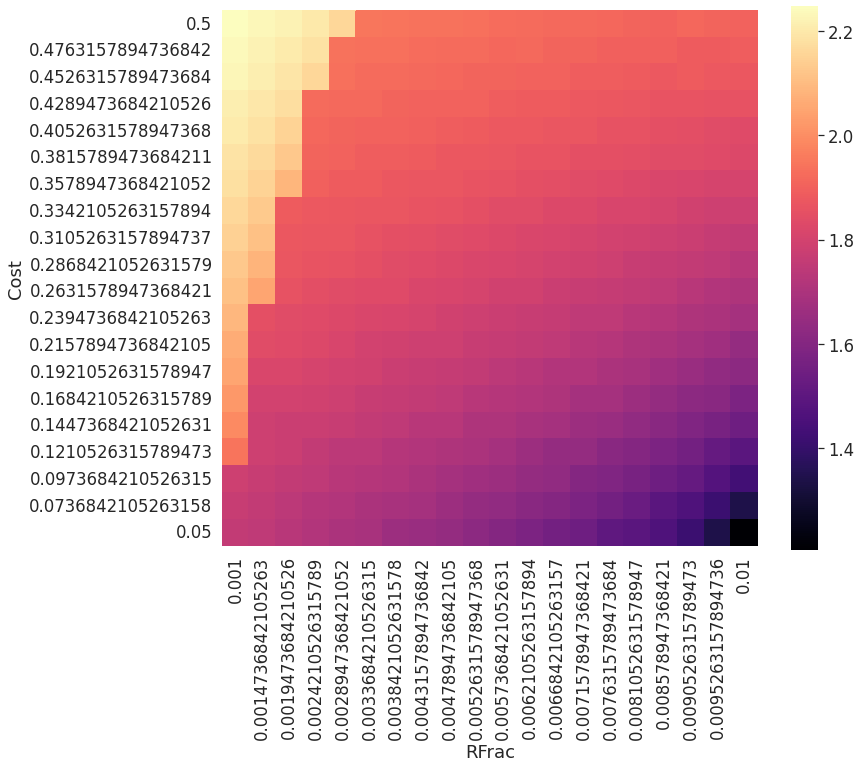

In [ ]:
# Reshape into a matrix
tmpDf = txComparisonDf.loc[txComparisonDf.TreatmentBranch=="0.5",["Cost","RFrac","AbsTimeGained"]].reset_index(drop=True)
tmpDf['Cost'] *= 1
tmpDf['RFrac'] *= 1
tmpDf['AbsTimeGained'] = np.log10(tmpDf['AbsTimeGained'])
#tmpDf.sortlevel(["Cost"], ascending=[False], sort_remaining=False)
timeToFailureMat = tmpDf.pivot("Cost","RFrac","AbsTimeGained")
timeToFailureMat.sort_index(level="Cost",ascending=False,inplace=True)


# Plot
fig, ax = plt.subplots(1,1,figsize=(12,10))
#ax.contourf(tmpDf.Cost.unique(),tmpDf.RFrac.unique(),timeToFailureMat,10,cmap=sns.cubehelix_palette(light=1, as_cmap=True))
#contours = ax.contour(tmpDf.Cost.unique(),tmpDf.RFrac.unique(),timeToFailureMat, 10, colors='black');
#plt.gca().set_facecolor('xkcd:light grey')
#plt.clabel(contours, inline=True, fontsize=28, fmt='%1.1f', rightside_up=True, )
g = sns.heatmap(data=timeToFailureMat,cmap='magma',square=True,cbar=True,ax=ax)
plt.savefig("myimg.svg")